<a href="https://colab.research.google.com/github/TripleGold3/kfp_test/blob/main/kan_for_no_convect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install fipy pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.1/446.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 7.5 MB/s eta 0:00:00


In [3]:
import numpy as np
from scipy.optimize import least_squares
from fipy import CellVariable, Grid2D, TransientTerm, DiffusionTerm, PowerLawConvectionTerm, numerix
import matplotlib.pyplot as plt
import time




def delta_func(x):
    eps = 0.5
    return ((x < eps/2.0) & (x > -eps/2.0)) * (1.0 / eps)


class DiffusionConvectionModel:
    def __init__(self, nx, ny, nt, xmin, xmax, ymin, ymax, tmin, tmax):
        self.nx, self.ny, self.nt = nx, ny, nt
        self.xmin, self.xmax, self.ymin, self.ymax, self.tmin, self.tmax = xmin, xmax, ymin, ymax, tmin, tmax
        self.dx = (xmax - xmin) / nx
        self.dy = (ymax - ymin) / ny
        self.dt = (tmax - tmin) / nt
        self.mesh = Grid2D(dx=self.dx, dy=self.dy, nx=nx, ny=ny)





    def simulate(self, S_values):
        x = self.mesh.x
        y = self.mesh.y
        init = 2.5 * delta_func(x - 3) * delta_func(y - 3)
        phi = CellVariable(name="solution variable", mesh=self.mesh)
        # 将源项参数化为 CellVariable，确保与期望的形式兼容
        phi.setValue(init)
        S = CellVariable(name="source term", mesh=self.mesh, value=0)
        S.setValue(S_values)

        convCoeff = ((1.,), (1.,))
        phi.faceGrad.constrain(((0,), (0,)), where=self.mesh.facesTop)
        phi.faceGrad.constrain(((0,), (0,)), where=self.mesh.facesBottom)
        phi.faceGrad.constrain(((0,), (0,)), where=self.mesh.facesLeft)
        phi.faceGrad.constrain(((0,), (0,)), where=self.mesh.facesRight)

        # eqX = TransientTerm() == DiffusionTerm(coeff=1.0) - PowerLawConvectionTerm(coeff=convCoeff) + S
        eqX = TransientTerm() == DiffusionTerm(coeff=1.0) + S

        res = []
        for n in range(self.nt):
            eqX.solve(var=phi, dt=self.dt)
            res.append(phi.value.copy())

        vle = numerix.asarray(res)
        # u = vle.reshape(nt, nx, ny)
        u = vle.reshape(self.nt, self.nx, self.ny)
        return u


def realSource():
    xmin = 0.;xmax = 5.;nx = int(20)
    ymin = 0.;ymax = 5.;ny = int(20)
    x_ = np.linspace(xmin, xmax, nx)
    y_ = np.linspace(ymin, ymax, ny)
    dx = x_[1] - x_[0]
    dy = y_[1] - y_[0]
    mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)
    x = mesh.x
    y = mesh.y


    source = 2.5 * delta_func(x - 3) * delta_func(y - 3)
    return source

def generate_data():
    # 定义模拟和观测数据参数
    nx, ny, nt = 20, 20, 101
    xmin, xmax, ymin, ymax, tmin, tmax = 0, 5, 0, 5, 0, 1
    diffusion_convection_model = DiffusionConvectionModel(nx, ny, nt, xmin, xmax, ymin, ymax, tmin, tmax)
    source = realSource()
    S_values = source
    u = diffusion_convection_model.simulate(S_values)

    return u


u = generate_data()






In [4]:
from kan import *
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
data = u

In [6]:
tmin = 0.;tmax = 1.;nt = int(100) + 1
xmin = 0.;xmax = 5.;nx = int(20)
ymin = 0.;ymax = 5.;ny = int(20)
t_ = np.linspace(tmin, tmax, nt)
x_ = np.linspace(xmin, xmax, nx)
y_ = np.linspace(ymin, ymax, ny)
T, X, Y = np.meshgrid(t_, x_, y_, indexing='ij')
# 展平为一维数组并堆叠为 (nx * ny * nt, 3) 形状
grid_flat = np.stack([T.ravel(), X.ravel(), Y.ravel()], axis=-1)

# 读取数据 (假设 data 的形状是 (nt, nx, ny))
data = u

# 展平数据为一维数组
data_flat = data.ravel()  # 将 (nt, nx, ny) 展平为 (nt * nx * ny)

In [7]:
domain =  torch.tensor(grid_flat, dtype=torch.float64, device=device)
concentration = torch.tensor(data.ravel(), dtype=torch.float64, device=device).unsqueeze(-1)
domain.shape, concentration.shape

(torch.Size([40400, 3]), torch.Size([40400, 1]))

In [8]:
import torch
from sklearn.model_selection import train_test_split  # 使用 sklearn 来方便拆分

# Step 1: 随机打乱并拆分数据集
# 获取样本的总数
n_samples = domain.shape[0]

# 通过 train_test_split 来拆分数据
# train_test_split 按照 50% 拆分，设置 shuffle=True 来打乱数据
domain_train, domain_test, concentration_train, concentration_test = train_test_split(
    domain, concentration, test_size=0.5, shuffle=True, random_state=42
)

# Step 2: 打印数据集的大小，确保已经成功拆分
print(f"Training set size: {domain_train.shape[0]}")
print(f"Test set size: {domain_test.shape[0]}")


Training set size: 20200
Test set size: 20200


In [9]:
kan_dataset = {}
kan_dataset['train_input'] = domain_train
kan_dataset['train_label'] = concentration_train
kan_dataset['test_input'] = domain_test
kan_dataset['test_label'] = concentration_test

In [10]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


model = KAN(width=[3,[0,2],  2,   1], grid=5, k=3,seed=42, device=device)

cuda
checkpoint directory created: ./model
saving model version 0.0


In [11]:
model(kan_dataset['train_input'])

tensor([[ 0.0723],
        [-0.0981],
        [ 0.0396],
        ...,
        [ 0.0590],
        [ 0.0184],
        [ 0.0208]], device='cuda:0', grad_fn=<AddBackward0>)

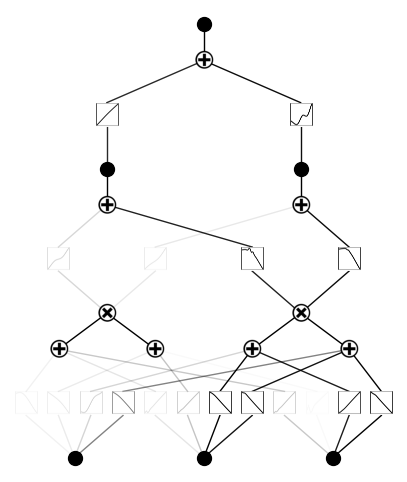

In [12]:
model.plot()

In [13]:
model.fit(kan_dataset, opt="LBFGS", steps=50, lamb=0.0001);

| train_loss: 1.08e-01 | test_loss: 1.19e-01 | reg: 1.91e+01 | : 100%|█| 50/50 [01:35<00:00,  1.90s/

saving model version 0.1


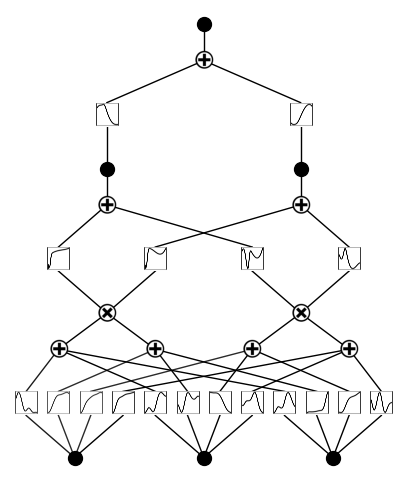

In [14]:
model.plot()

In [15]:
model = model.refine(10)

saving model version 0.2


In [16]:
model.fit(kan_dataset, opt="LBFGS", steps=50);

| train_loss: 6.77e-02 | test_loss: 8.60e-02 | reg: 2.74e+01 | : 100%|█| 50/50 [01:25<00:00,  1.71s/

saving model version 0.3


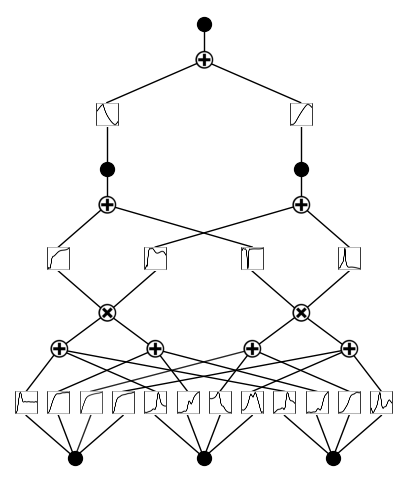

In [17]:
model.plot()

In [18]:
model.auto_symbolic()

fixing (0,0,0) with 0, r2=0.0, c=0
fixing (0,0,1) with 0, r2=0.0, c=0
fixing (0,0,2) with exp, r2=0.9965100041648046, c=2
fixing (0,0,3) with 0, r2=0.0, c=0
fixing (0,1,0) with 0, r2=0.0, c=0
fixing (0,1,1) with 0, r2=0.0, c=0
fixing (0,1,2) with 0, r2=0.0, c=0
fixing (0,1,3) with 0, r2=0.0, c=0
fixing (0,2,0) with 0, r2=0.0, c=0
fixing (0,2,1) with 0, r2=0.0, c=0
fixing (0,2,2) with 0, r2=0.0, c=0
fixing (0,2,3) with 0, r2=0.0, c=0
fixing (1,0,0) with 0, r2=0.0, c=0
fixing (1,0,1) with 0, r2=0.0, c=0
fixing (1,1,0) with 0, r2=0.0, c=0
fixing (1,1,1) with 0, r2=0.0, c=0
fixing (2,0,0) with 0, r2=0.0, c=0
fixing (2,1,0) with cos, r2=0.9993623271229265, c=2
saving model version 0.4


In [19]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

0.2679